![AIcrowd-Logo](https://images.aicrowd.com/raw_images/challenges/banner_file/677/b1c94f799d0062e9b50b.jpg)


## Starter Kit for [Sound Sentiment Prediction Puzzle](https://www.aicrowd.com/blitz/puzzles/sound-sentiment-prediction)

## Let's import necessary packages!

In [ ]:
!pip install --upgrade fastai
!pip install librosa

In [ ]:
import sys
import zipfile
import librosa
import pandas as pd
import cv2
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.vision.data import *
from fastai.vision.all import *
import fastai

## Download the dataset

In [ ]:
zip_data = False

In [ ]:
if zip_data:
    zip_path = r"C:\Users\alice\Desktop\UNIBO\2_Anno\2_semestre\PW-Deep\SoundSentimentClassification\Dataset"

    with zipfile.ZipFile(zip_path + "\\train.zip", 'r') as zip_ref:
        zip_ref.extractall(zip_path + "\\train") 

## Load Data

In [ ]:
train_df = pd.read_csv("train.csv")[:50]
train_df.head()

,label,wav_id
0,2,0
1,2,1
2,2,2
3,2,3
4,2,4


## Preprocessing Data

#### 1' approach: Convert audio signal into images
Train a Convolutional neural network with them

In [ ]:
training_sound_paths = os.listdir("train")[:50]

train_df['name'] = "./spec_imgs/" + train_df['wav_id'].astype(str) + ".jpg"

In [ ]:
os.mkdir("spec_imgs")

def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zeroPrepare a CSV containing wav_id and predicted value as digit [0-2] respectively denoting positive, neutral, and negative reviews.
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

for n, sound_path in enumerate(training_sound_paths):
    y, sr = librosa.load(f"train/{sound_path}")
    total_secs = y.shape[0] / sr
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    M = librosa.power_to_db(M)
    M = mono_to_color(M)
    # Prepare a CSV containing wav_id and predicted value as digit [0-2] respectively denoting positive, neutral, and negative reviews.

    cv2.imwrite(f"./spec_imgs/{n}.jpg", M, [int(cv2.IMWRITE_JPEG_QUALITY), 85])

In [ ]:
train_df.label = train_df.label.astype(str)
train_df.head(3)

,label,wav_id,name
0,2,0,./spec_imgs/0.jpg


In [ ]:
dls = ImageDataLoaders.from_df(train_df,path='.', label_col=0, fn_col=2, item_tfms=Resize(224), bs=5, num_workers=0)

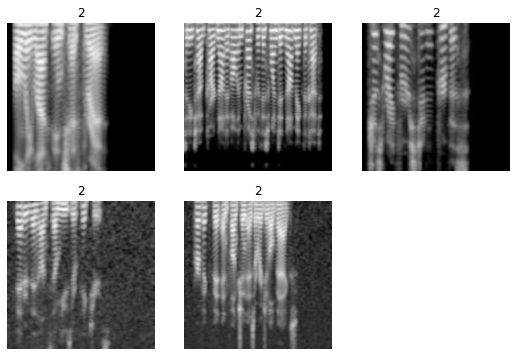

In [ ]:
dls.show_batch()

## Train the CNN model

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(1)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.016618,1.297288,0.600000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.175006,1.365746,0.400000,00:01


In [ ]:
# learn = vision_learner(dls, resnet34, metrics=accuracy)
# learn.fine_tune(1)

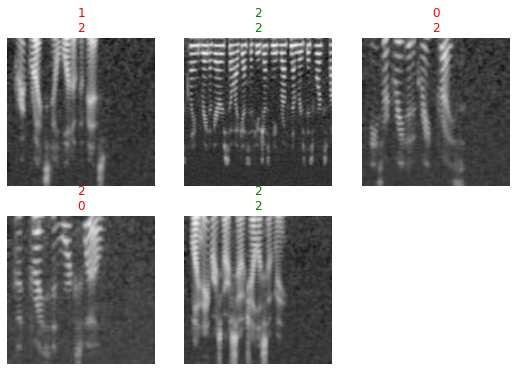

In [ ]:
learn.show_results()

## Generating predictions

In [ ]:
os.makedirs("test_spec_imgs", exist_ok=True)

test_sound_paths = os.listdir("test")

test_img_paths = []
for n, sound_path in enumerate(test_sound_paths):
    y, sr = librosa.load(f"test/{sound_path}")
    total_secs = y.shape[0] / sr
    M = librosa.feature.melspectrogram(y=y, sr=sr)
    M = librosa.power_to_db(M)
    M = mono_to_color(M)

    cv2.imwrite(f"./test_spec_imgs/{n}.jpg", M, [int(cv2.IMWRITE_JPEG_QUALITY), 85])
    test_img_paths.append(f"./test_spec_imgs/{n}.jpg")

In [ ]:
test_predictions = []

for test_img_path in test_img_paths:
  prediction = learn.predict(test_img_path)
  test_predictions.append(int(prediction[0][0]))

Output hidden; open in https://colab.research.google.com to view.

## Let's make the final file with the results

In [ ]:
test_img_paths = [int(i.split(".")[-2].split("/")[-1]) for i in test_img_paths]
submission = pd.DataFrame({"wav_id":test_img_paths, "label":test_predictions})
submission

In [ ]:
submission.to_csv("submission.csv", index=False)

## 2' approach: extract the text from the sound signal and perform a sentiment analysis on them

## 3' approeach: combine the First and Second approaches